# Student Grade Prediction - Kaggle Playground S6E1

This notebook develops machine learning models to predict the `exam_score` variable from synthetic educational data with 900,000 records, containing demographic information, study habits, and environmental factors.

## Structure

1. Environment setup  
2. Exploratory analysis  
3. Preprocessing and feature engineering  
4. Individual modeling (RF, XGBoost, LightGBM, CatBoost)  
5. Ensemble and submission generation


# 1. Environment setup

-----------

In [5]:
# Installation of all necessary dependencies
!pip install -q optuna xgboost lightgbm catboost scikit-learn pandas numpy matplotlib seaborn tqdm


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.base import clone


## 1.1 Data loading


In [7]:
test = pd.read_csv("data/test.csv")
train = pd.read_csv("data/train.csv")

In [8]:
train.head()

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0


The dataset contains:  

- **Demographics**: `age`, `gender`, `course`  
- **Study habits**: `study_hours`, `class_attendance`, `study_method`  
- **Environmental factors**: `internet_access`, `sleep_hours`, `sleep_quality`  
- **Infrastructure**: `facility_rating`, `exam_difficulty`  
- **Target**: `exam_score`.[file:1]


In [9]:
test.head(0)

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty


#### Test Data Structure

The test data does not have the target variable `exam_score`, which is the value to be predicted.

In [10]:
print(train.shape) #training data
print(test.shape) #test data

(630000, 13)
(270000, 12)


#### Dataset Dimensions

- **Total records**: 900,000
- **Training data**: 630,000 (70%)
- **Test data**: 270,000 (30%)

In [11]:
print(train.isnull().sum())
print(test.isnull().sum())

id                  0
age                 0
gender              0
course              0
study_hours         0
class_attendance    0
internet_access     0
sleep_hours         0
sleep_quality       0
study_method        0
facility_rating     0
exam_difficulty     0
exam_score          0
dtype: int64
id                  0
age                 0
gender              0
course              0
study_hours         0
class_attendance    0
internet_access     0
sleep_hours         0
sleep_quality       0
study_method        0
facility_rating     0
exam_difficulty     0
dtype: int64


#### Data Quality

No null values were identified in the training and test datasets, indicating good data quality.

In [12]:
test.describe()

,id,age,study_hours,class_attendance,sleep_hours
count,270000.000000,270000.000000,270000.000000,270000.000000,270000.000000
mean,764999.500000,20.544137,4.003878,71.982509,7.072070
std,77942.430678,2.260452,2.357741,17.414695,1.745513
min,630000.000000,17.000000,0.080000,40.600000,4.100000
25%,697499.750000,19.000000,1.980000,57.000000,5.600000
50%,764999.500000,21.000000,4.010000,72.600000,7.100000
75%,832499.250000,23.000000,6.050000,87.200000,8.600000
max,899999.000000,24.000000,7.910000,99.400000,9.900000


## 1.2 Feature and Target Separation

The data is divided into features (independent variables) and target (dependent variable).

In [13]:
#Column definition
target = "exam_score"
id_col = "id"

numeric_features = ["age", "study_hours", "class_attendance", "sleep_hours"]  #numeric data
categorical_features = [#categorical data -> Non-numeric
    "gender", 
    "course", 
    "internet_access",
    "sleep_quality",
    "study_method",
    "facility_rating",
    "exam_difficulty",
]  
X = train.drop([id_col, target], axis=1) #removes id_col and target columns, keeping only training features.
y = train[target] #defines the training target as Exam_score
X_test = test.drop([id_col], axis=1) #removes id_col from test x, since it will not be taken into account in the analysis.

print(X.shape)
print(y.shape)
print(X_test.shape)


(630000, 11)
(630000,)
(270000, 11)


# 2. Exploratory Data Analysis

-----------


## 2.1 Target Variable Analysis

In this section, exploratory data analysis is performed to understand distributions and correlations.

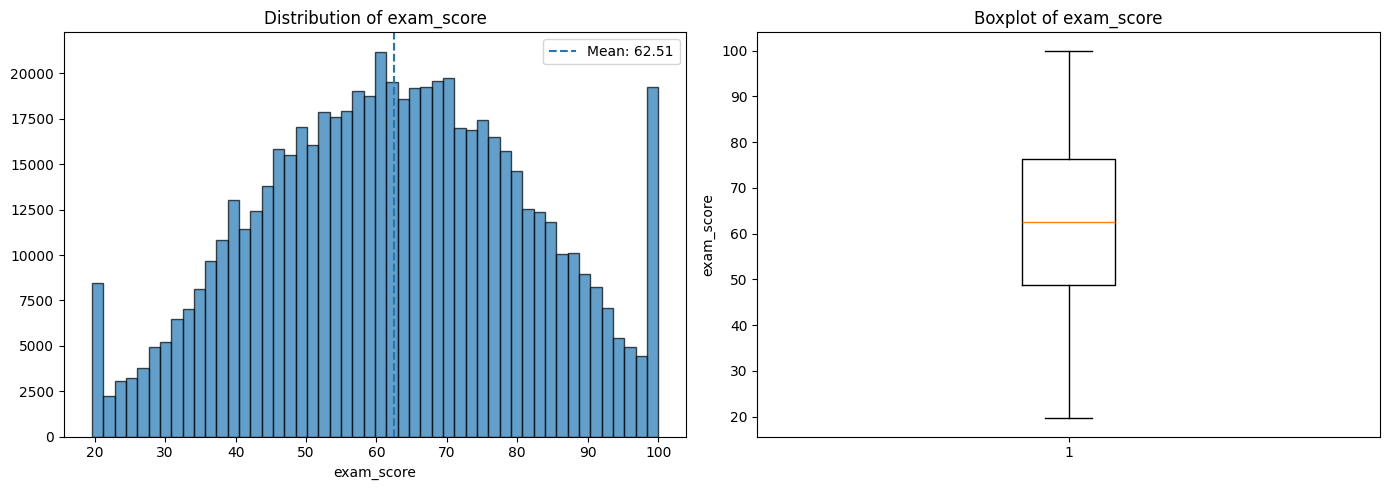

In [14]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(y, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of exam_score')
axes[0].set_xlabel('exam_score')
axes[0].axvline(y.mean(), linestyle='--', label=f'Mean: {y.mean():.2f}')
axes[0].legend()

# Boxplot
axes[1].boxplot(y)
axes[1].set_title('Boxplot of exam_score')
axes[1].set_ylabel('exam_score')

plt.tight_layout()
plt.show()

Observations:  

- Median close to the mean, suggesting a relatively symmetric distribution.  
- Higher density of values between 50 and 75 points.  
- A maioria dos estudantes apresenta desempenho de mean a bom.


## 2.2 Correlation between numeric variables


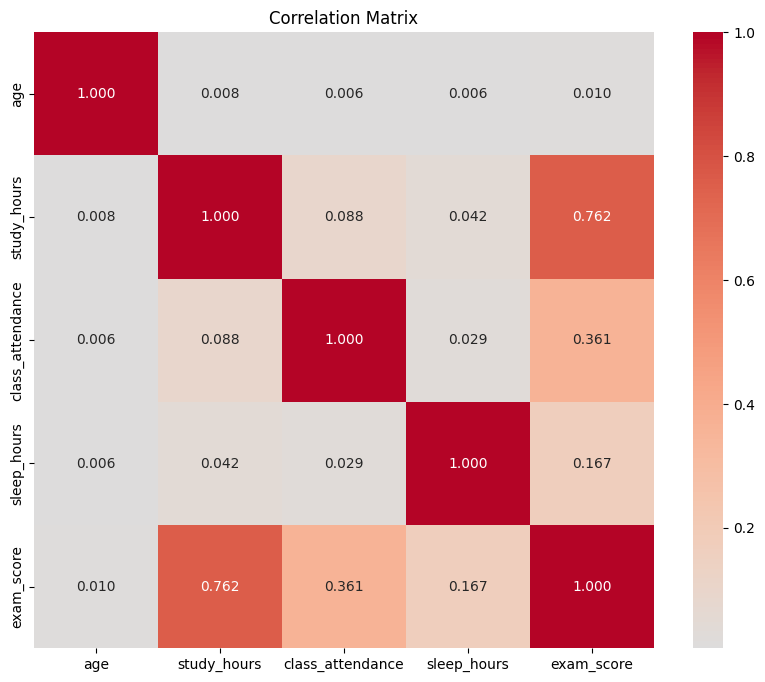

Correlation target:
exam_score          1.000000
study_hours         0.762267
class_attendance    0.360954
sleep_hours         0.167410
age                 0.010472
Name: exam_score, dtype: float64


In [15]:
#Correlation between numeric variables
numeric_data = train[numeric_features + [target]] #only numeric features and what we want to analyze
correlation_matrix = numeric_data.corr() #applies correlation

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0) #heat map, the more towards red the higher the correlation
plt.title('Correlation Matrix')
plt.show()
print("Correlation target:")
print(correlation_matrix[target].sort_values(ascending=False))


Main correlations with `exam_score`:  
- `study_hours` with high positive correlation (~0.76).  
- `class_attendance` with moderate positive correlation (~0.36).  
- `sleep_hours` com correlação positiva mais fraca (~0.17).  
- `age` praticamente sem correlação.[file:1]


## 2.3 Categorical Variables Analysis


In [16]:
from IPython.display import display

# Average exam_score by category
for col in categorical_features:
    means = (
        train.groupby(col)[target]# groups each categorical column with the target,
        .mean()    #calculating the average exam score for each column value
        .sort_values(ascending=False)
    )
    
    # shows the column name
    print(f"\n{col}:")
    display(means)#display prevents output from being cut in Jupyter



gender:


gender
other     62.781191
female    62.563220
male      62.175561
Name: exam_score, dtype: float64


course:


course
bba        63.232038
bca        62.586227
b.com      62.537726
b.tech     62.519707
diploma    62.404354
b.sc       62.295491
ba         61.886931
Name: exam_score, dtype: float64


internet_access:


internet_access
yes    62.509172
no     62.478038
Name: exam_score, dtype: float64


sleep_quality:


sleep_quality
good       67.884885
average    62.662000
poor       56.995470
Name: exam_score, dtype: float64


study_method:


study_method
coaching         69.266665
mixed            65.101735
group study      60.531838
online videos    59.727607
self-study       57.700155
Name: exam_score, dtype: float64


facility_rating:


facility_rating
high      66.707126
medium    63.028954
low       57.954546
Name: exam_score, dtype: float64


exam_difficulty:


exam_difficulty
hard        62.671693
moderate    62.606060
easy        62.214401
Name: exam_score, dtype: float64

Data by category (examples): 

- `sleep_quality`: good sleep quality has a clearly higher average than poor quality.  
- `study_method`: methods with coaching show higher averages; isolated self-study is among the lowest.  
- `facility_rating`: better infrastructure ratings are associated with higher grades.


# 3. Data Preprocessing

--------

## 3.1 Categorical Variables Transformation

Categorical variables need to be converted to numeric for use in machine learning models.

#### Label Encoding Process

LabelEncoder is applied to transform categorical variables into numeric ones, maintaining consistency between training and test datasets.

In [17]:
from sklearn.preprocessing import LabelEncoder

# Step 1: Make independent copies of the data to protect x and x_test
X_transf = X.copy()
X_test_transf = X_test.copy()
#print(X_enconder) #we see it has numeric and categorical data. We only want categorical for string manipulation

# Step 2: separate the copies with only categorical data
X_transf_categories = X_transf[categorical_features]
X_test_transf_categories = X_test_transf[categorical_features]
#print(X_enconder_cat) #now we see only categorical data remained

# Step 3: Loop to apply the transformation for each column
for col in categorical_features: #for each categorical variable column:
  le = LabelEncoder() #label encoder model
  combined = pd.concat([
      X_transf_categories[col],
      X_test_transf_categories[col]
  ])  #joins the training and test dataframe into one to ensure no label is missing in the analysis

  le.fit(combined.astype(str)) #applies the encoder model on the combined data variable
   # - First converts to string
   # - Removes duplicates
   # - Alphabetically sorts the labels
   # - Creates internal mapping. Example -> ['Female', 'Male','other'] -> [0,1,2]
   # astype(str) prevents random numeric data or NAN type from being taken into account in the transformation

   #Step 4: apply to test and training dataframes
  X_transf[col] = le.transform(X_transf_categories[col].astype(str)) #for each training column applies the transformation by the model above
  X_test_transf[col] = le.transform(X_test_transf_categories[col].astype(str)) #for each test column applies the transformation by the model above

#step 5: visualize how the dataframes turned out:
print(X_transf) #TRAINING
print(X_test_transf) #test


        age  gender  course  study_hours  class_attendance  internet_access  \
0        21       0       1         7.91              98.8                0   
1        18       2       6         4.95              94.8                1   
2        20       0       1         4.68              92.6                1   
3        19       1       1         2.00              49.5                1   
4        23       1       5         7.65              86.9                1   
...     ...     ...     ...          ...               ...              ...   
629995   18       0       2         4.86              70.7                1   
629996   21       0       3         7.08              54.4                1   
629997   24       1       5         0.64              44.2                1   
629998   20       1       0         1.54              75.1                1   
629999   18       2       2         3.94              75.3                1   

        sleep_hours  sleep_quality  study_method  f

# 4. Evaluation function (cross-validation)

--------

In this section, cross-validation schemes are defined and applied for Individual Models (Random Forest, XGBoost, LightGBM, CatBoost).  


- Model validation:

In [20]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.base import clone
import numpy as np

def evaluate_model_cv(model, X, y, cv=5):
    """
    Evaluates a model using KFold and returns the RMSE of each fold.
    Uses MANUAL validation for ALL models (avoids cross_val_score hanging).
    """
    kfold = KFold(n_splits=cv, shuffle=True, random_state=42)
    rmse_scores = []
    
    for train_idx, val_idx in kfold.split(X):
        X_train_fold = X.iloc[train_idx]
        y_train_fold = y.iloc[train_idx]
        X_val_fold = X.iloc[val_idx]
        y_val_fold = y.iloc[val_idx]

        # Clone for each fold
        model_fold = clone(model)
        
        # Fit (without n_jobs=-1 to avoid overhead)
        model_fold.fit(X_train_fold, y_train_fold)
        
        # Predict and RMSE
        pred = model_fold.predict(X_val_fold)
        rmse = np.sqrt(mean_squared_error(y_val_fold, pred))
        rmse_scores.append(rmse)

    return np.array(rmse_scores)


# 5. Models

---------

In [21]:
test_ids = test["id"].values  # IDs for ALL submissions

## 5.1. Decision Tree


---------------

In [22]:
from sklearn.tree import DecisionTreeRegressor

# Simple decision tree with 1 tree (baseline)
dt_model = DecisionTreeRegressor(
    max_depth=None,      # Complete tree (no pruning)
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)

# Train with all data
dt_model.fit(X_transf, y)

# Prediction on test
pred_dt_test = dt_model.predict(X_test_transf)

# Immediate submission
submission_dt = pd.DataFrame({
    'id': test_ids,
    'examscore': pred_dt_test
})
submission_dt.to_csv('submission_dt_individual.csv', index=False)

print("Decision Tree Submission (1 tree) saved")
print("Expected RMSE: simple baseline")
print(submission_dt.head())


Decision Tree Submission (1 tree) saved
Expected RMSE: simple baseline
       id  examscore
0  630000  60.885714
1  630001  70.460000
2  630002  84.687500
3  630003  43.862500
4  630004  53.571429


## 5.2. Random Forest

--------------

In [23]:
from sklearn.ensemble import RandomForestRegressor

In [24]:
n_estimators_list = [5, 10, 20, 50, 100]# List of values for number of trees

rmse_means = [] #Stores RMSE averages

for n in n_estimators_list:

    rf_model = RandomForestRegressor( #random forest model
        n_estimators=n, #number of trees that will perform analysis -> takes from vector above
        max_depth=15,   #maximum depth of trees
        random_state=42, #random state to ensure reproducibility
        n_jobs=-1
    )

    #use of cross-validation on the model above
    # X_transf -> Training features
    # y -> Training target
    # cv -> number of divisions
    rmse_scores = evaluate_model_cv(rf_model, X_transf, y, cv=5)

    #evaluate_model will return rmse_scores as positive
    #it will return a value for each fold, in this case an array with 5 values
    #example: [2.31, 2.45, 2.28, 2.40, 2.35]
    rmse_mean = rmse_scores.mean()
    rmse_means.append(rmse_mean)
    print(f"n_estimators = {n} -> Mean RMSE: {rmse_mean:.4f}")#print performance for each number of trees

# identify the best number of trees (lowest mean RMSE)
best_idx = np.argmin(rmse_means)
best_n_estimators = n_estimators_list[best_idx]
best_rmse = rmse_means[best_idx]

print("\nBest configuration found:")
print(f"n_estimators = {best_n_estimators} with Mean RMSE = {best_rmse:.4f}")


plt.figure(figsize=(8, 5))
plt.plot(n_estimators_list, rmse_means, marker='o')

plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Mean RMSE (Cross Validation)")
plt.title("Evolution of Mean RMSE with Number of Trees - Random Forest")
plt.grid(True)
plt.show()

n_estimators = 5 -> Mean RMSE: 9.1859
n_estimators = 10 -> Mean RMSE: 9.0628
n_estimators = 20 -> Mean RMSE: 8.9997
n_estimators = 50 -> Mean RMSE: 8.9621


KeyboardInterrupt: 

In [ ]:
print(f"Training final model with n_estimators = {best_n_estimators}...")

rf_final = RandomForestRegressor(
    n_estimators=best_n_estimators,  # Best value found
    max_depth=15, 
    random_state=42,
    n_jobs=-1  # Uses all available cores
)

rf_final.fit(X_transf, y)  # Train with all training data

y_pred_test = rf_final.predict(X_test_transf)  # Prediction on test set

submission_rf = pd.DataFrame({
    'id': test_ids,       # Uses test_ids (defined earlier)
    'examscore': y_pred_test  # Correct name of Kaggle column
})

submission_rf.to_csv('submission_rf_individual.csv', index=False)  # Standardized name
print("First lines of Random Forest submission:")
print(submission_rf.head())

## 5.3. XGBoost


--------

In [ ]:
import optuna
from xgboost import XGBRegressor

#Objective function for Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2500),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'tree_method': 'hist',
        'n_jobs': 1,
        'random_state': 42
    }
    #Create XGBoost model
    xgb_model = XGBRegressor(**params)
    
    #Use of cross-validation on the model above
    # X_transf -> Training features
    # y -> Training target
    # cv -> number of divisions
    rmse_scores = evaluate_model_cv(xgb_model, X_transf, y, cv=5)
    
    #evaluate_model will return rmse_scores as positive
    #It will return a value for each fold, in this case an array with 5 values
    #Example: [2.31, 2.45, 2.28, 2.40, 2.35]
    rmse_mean = rmse_scores.mean()
    
    return rmse_mean

#Create Optuna study and optimize
print("Starting hyperparameter optimization with Optuna...")
study = optuna.create_study(direction='minimize')  # Minimize RMSE
study.optimize(objective, n_trials=25, show_progress_bar= True)  # Number of trials
best_params = study.best_params#Identify the best hyperparameters
best_rmse = study.best_value

print("\nBest configuration found:")
print(f"Best hyperparameters: {best_params}")
print(f"Mean RMSE = {best_rmse:.4f}")

## 5.4. LightGBM

------------

In [ ]:
import optuna
from lightgbm import LGBMRegressor


#Objective function for Optuna
def objective(trial):
    #Define hyperparameters to be optimized
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2500),  # Number of trees
        'max_depth': trial.suggest_int('max_depth', 3, 15),  # Maximum depth of trees
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),  # Learning rate
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),  # Fraction of samples for each tree
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),  # Fraction of features
        'random_state': 42,
        'n_jobs': 1
    }
    
    #Create LightGBM model
    lgbm_model = LGBMRegressor(**params)
    
    #Use of cross-validation on the model above
    # X_transf -> Training features
    # y -> Training target
    # cv -> number of divisions
    rmse_scores = evaluate_model_cv(lgbm_model, X_transf, y, cv=5)
    
    #evaluate_model will return rmse_scores as positive
    #It will return a value for each fold, in this case an array with 5 values
    #Example: [2.31, 2.45, 2.28, 2.40, 2.35]
    rmse_mean = rmse_scores.mean()
    
    return rmse_mean

#Create Optuna study and optimize
print("Starting hyperparameter optimization with Optuna...")
study = optuna.create_study(direction='minimize')  # Minimize RMSE
study.optimize(objective, n_trials=25, show_progress_bar= True)  # Number of trials
best_params = study.best_params#Identify the best hyperparameters
best_rmse = study.best_value


print("\nBest configuration found:")
print(f"Best hyperparameters: {best_params}")
print(f"Mean RMSE = {best_rmse:.4f}")

## 5.5. CatBoost

----------------

In [ ]:
import optuna
from catboost import CatBoostRegressor
import numpy as np

# Objective function for Optuna
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 2500),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'bootstrap_type': 'Bernoulli',
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'random_seed': 42,
        'thread_count': -1,  #all cores
        'verbose': False
    }
    
    # Create model with suggested parameters
    model = CatBoostRegressor(**params)
    rmse_scores = evaluate_model_cv(model, X_transf, y, cv=5)
    mean_rmse = np.mean(rmse_scores)
    
    return mean_rmse

# Execute optimization
print("Starting hyperparameter optimization with Optuna...")
print(f"Dataset: {X_transf.shape[0]} rows, {X_transf.shape[1]} features")
print("="*60)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25, show_progress_bar=True)

# Results
print("\n" + "="*60)
print("OPTIMIZATION RESULTS")
print("="*60)
print(f"Best RMSE (CV mean): {study.best_value:.4f}")
print("\nBest parameters found:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")
print("="*60)

# 6. Individual submissions by model

------------

## 6.1. XGBoost Model

In [ ]:
from xgboost import XGBRegressor

# Best XGBoost hyperparameters from Optuna (RMSE: 8.7300)
best_params_xgb = {
    'n_estimators': 1145,
    'max_depth': 7,
    'learning_rate': 0.04269262045629722,
    'subsample': 0.8739697774837054,
    'colsample_bytree': 0.9928865587917701,
    'colsample_bylevel': 0.9744161297574184,
    'colsample_bynode': 0.6681144843894893,
    'reg_alpha': 0.5332289367881878,
    'reg_lambda': 1.7393417559849508e-05,
    'gamma': 4.524129691822362,
    'min_child_weight': 2
}

# Train XGBoost with best parameters on all training data
xgb_model_individual = XGBRegressor(**best_params_xgb, random_state=42, n_jobs=-1)
xgb_model_individual.fit(X_transf, y)

# Prediction on test set
pred_xgb_test = xgb_model_individual.predict(X_test_transf)

# Generate submission file
submission_xgb = pd.DataFrame({'id': test_ids, 'exam_score': pred_xgb_test})
submission_xgb.to_csv('submission_xgb_individual.csv', index=False)
print("Individual XGBoost submission saved")
print(submission_xgb.head())


## 6.2. LightGBM Model

In [ ]:
from lightgbm import LGBMRegressor

# Best LightGBM hyperparameters from Optuna (RMSE: 8.7358)
best_params_lgbm = {
    'n_estimators': 2474,
    'max_depth': 14,
    'learning_rate': 0.04729004562661403,
    'subsample': 0.9237994273727859,
    'colsample_bytree': 0.7615157452816664
}

# Train LightGBM with best parameters on all training data
lgbm_model_individual = LGBMRegressor(**best_params_lgbm, random_state=42, verbose=-1, n_jobs=-1)
lgbm_model_individual.fit(X_transf.astype(np.float32), y.astype(np.float32))

# Prediction on test set
pred_lgbm_test = lgbm_model_individual.predict(X_test_transf.astype(np.float32))

# Generate submission file
submission_lgbm = pd.DataFrame({'id': test_ids, 'exam_score': pred_lgbm_test})
submission_lgbm.to_csv('submission_lgbm_individual.csv', index=False)
print("Individual LightGBM submission saved")
print(submission_lgbm.head())

## 6.3 CatBoost Model

In [ ]:
from catboost import CatBoostRegressor

# Best CatBoost hyperparameters from Optuna (RMSE: 8.7490)
best_params_catboost = {
    'iterations': 2458,
    'depth': 7,
    'learning_rate': 0.05401634937628759,
    'subsample': 0.9613602990809382
}

# Train CatBoost with best parameters on all training data
catboost_model_individual = CatBoostRegressor(**best_params_catboost, random_state=42, verbose=False)
catboost_model_individual.fit(X_transf, y)

# Prediction on test set
pred_catboost_test = catboost_model_individual.predict(X_test_transf)

# Generate submission file
submission_catboost = pd.DataFrame({'id': test_ids, 'exam_score': pred_catboost_test})
submission_catboost.to_csv('submission_catboost_individual.csv', index=False)
print("Individual CatBoost submission saved")
print(submission_catboost.head())


# 7. Ensemble (XGBoost + LightGBM + CatBoost)

-------

In [ ]:
import gc
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [ ]:
print("=" * 50)
print("ENSEMBLE WITH CROSS VALIDATION")
print("=" * 50)
print(f"Total features: {X_transf.shape[1]}")
print(f"Training samples: {X_transf.shape[0]}")
print(f"Test samples: {X_test_transf.shape[0]}")

In [ ]:
xgb_model = XGBRegressor(
    n_estimators=1145,
    max_depth=7,
    learning_rate=0.04269262045629722,
    subsample=0.8739697774837054,
    colsample_bytree=0.9928865587917701,
    colsample_bylevel=0.9744161297574184,
    colsample_bynode=0.6681144843894893,
    reg_alpha=0.5332289367881878,
    reg_lambda=1.7393417559849508e-05,
    gamma=4.524129691822362,
    min_child_weight=2,
    random_state=42,
    n_jobs=-1,
    tree_method="hist"
)

# LightGBM - Best parameters from Optuna (RMSE: 8.7358)
lgbm_model = LGBMRegressor(
    n_estimators=2474,
    max_depth=14,
    learning_rate=0.04729004562661403,
    subsample=0.9237994273727859,
    colsample_bytree=0.7615157452816664,
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    max_bin=255,
    force_col_wise=True,
    min_data_in_leaf=20
)

# CatBoost - Best parameters from Optuna (RMSE: 8.7490)
catboost_model = CatBoostRegressor(
    iterations=2458,
    depth=7,
    learning_rate=0.05401634937628759,
    subsample=0.9613602990809382,
    random_seed=42,
    verbose=False,
    thread_count=-1
)

In [ ]:
#weight for each model
peso_xgb = 0.5
peso_lgbm = 0.35
peso_catboost = 0.15

#STORES THE RMSE OF EACH CROSS-VALIDATION FOLD
rmse_xgb_cv = []
rmse_lgbm_cv = []
rmse_catboost_cv = []
rmse_ensemble_simples_cv = []
rmse_ensemble_ponderado_cv = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("\nExecuting cross validation...")
for fold, (train_idx, val_idx) in enumerate(kf.split(X_transf), 1):
    print(f"\nFold {fold}/5:", end=" ")
    
    X_train_fold = X_transf.iloc[train_idx]
    y_train_fold = y.iloc[train_idx]
    X_val_fold = X_transf.iloc[val_idx]
    y_val_fold = y.iloc[val_idx]
    
    # XGBoost
    xgb_fold = XGBRegressor(**xgb_model.get_params())
    xgb_fold.fit(X_train_fold, y_train_fold)
    pred_xgb_val = xgb_fold.predict(X_val_fold)
    rmse_xgb = np.sqrt(mean_squared_error(y_val_fold, pred_xgb_val))
    rmse_xgb_cv.append(rmse_xgb)
    print(f"XGB={rmse_xgb:.4f}", end=" | ")
    
    # LightGBM
    lgbm_fold = LGBMRegressor(**lgbm_model.get_params())
    lgbm_fold.fit(
        X_train_fold.astype(np.float32),
        y_train_fold.astype(np.float32),
    )
    pred_lgbm_val = lgbm_fold.predict(X_val_fold.astype(np.float32))
    rmse_lgbm = np.sqrt(mean_squared_error(y_val_fold, pred_lgbm_val))
    rmse_lgbm_cv.append(rmse_lgbm)
    print(f"LGBM={rmse_lgbm:.4f}", end=" | ")
    
    # CatBoost
    catboost_fold = CatBoostRegressor(**catboost_model.get_params())
    catboost_fold.fit(X_train_fold, y_train_fold)
    pred_catboost_val = catboost_fold.predict(X_val_fold)
    rmse_catboost = np.sqrt(mean_squared_error(y_val_fold, pred_catboost_val))
    rmse_catboost_cv.append(rmse_catboost)
    print(f"CAT={rmse_catboost:.4f}", end=" | ")
    
    # Simple ensemble
    pred_ensemble_simples_val = (
        pred_xgb_val + pred_lgbm_val + pred_catboost_val
    ) / 3
    rmse_ensemble_simples = np.sqrt(mean_squared_error(y_val_fold, pred_ensemble_simples_val))
    rmse_ensemble_simples_cv.append(rmse_ensemble_simples)
    print(f"ENS_SIMPLES={rmse_ensemble_simples:.4f}", end=" | ")
    
    # Weighted ensemble
    pred_ensemble_ponderado_val = (
        pred_xgb_val * peso_xgb +
        pred_lgbm_val * peso_lgbm +
        pred_catboost_val * peso_catboost
    )
    rmse_ensemble_ponderado = np.sqrt(mean_squared_error(y_val_fold, pred_ensemble_ponderado_val))
    rmse_ensemble_ponderado_cv.append(rmse_ensemble_ponderado)
    print(f"ENS_PONDERADO={rmse_ensemble_ponderado:.4f}")
    
    gc.collect()

In [ ]:
# Final training on complete data
xgb_model.fit(X_transf, y)
lgbm_model.fit(X_transf.astype(np.float32), y.astype(np.float32))
catboost_model.fit(X_transf, y)

# Predictions on test
pred_xgb = xgb_model.predict(X_test_transf)
pred_lgbm = lgbm_model.predict(X_test_transf.astype(np.float32))
pred_catboost = catboost_model.predict(X_test_transf)

In [ ]:
# Simple and weighted ensemble
pred_ensemble_simples = (pred_xgb + pred_lgbm + pred_catboost) / 3

pred_ensemble_ponderado = (
    pred_xgb * peso_xgb
    + pred_lgbm * peso_lgbm
    + pred_catboost * peso_catboost
)

In [ ]:
# Submission: simple ensemble
submission_simples = pd.DataFrame(
    {
        "id": test_ids,
        "exam_score": pred_ensemble_simples,
    }
)
submission_simples.to_csv("submission_ensemble_simples.csv", index=False)

In [ ]:
# Submission: weighted ensemble
submission_ponderado = pd.DataFrame(
    {
        "id": test_ids,
        "exam_score": pred_ensemble_ponderado,
    }
)
submission_ponderado.to_csv("submission_ensemble_ponderado.csv", index=False)